In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (8, 5)

from tqdm.auto import tqdm
from IPython.display import clear_output

from sklearn.preprocessing import LabelEncoder, StandardScaler

In [2]:
!pip install opendatasets
import opendatasets as od

od.download('https://www.kaggle.com/competitions/hse-dab-lt-naf-22/data')

!pip install kmodes
!pip install --upgrade kmodes
from kmodes.kmodes import KModes

clear_output()

In [3]:
LOCATION = pd.read_csv('hse-dab-lt-naf-22/LOCATION.csv', sep=';')
loc_len = len(LOCATION)
cols_to_drop = []
for col in LOCATION.columns:
    v_c = LOCATION[col].value_counts()
    if len(v_c) <= 1 or v_c.iloc[0] > loc_len * 0.95:
        cols_to_drop.append(col)
LOCATION.drop(columns=cols_to_drop, inplace=True)
LOCATION.rename(columns={'STORE_LOCATION_RK':'location_id'}, inplace=True)
for col in LOCATION.columns:
    if col.find('hashing') != -1:
        LOCATION[col] = LabelEncoder().fit_transform(LOCATION[col])
LOCATION.drop(columns=LOCATION.columns.intersection(['VALID_FROM_DTTM']), inplace=True)



PRODUCT = pd.read_csv('hse-dab-lt-naf-22/PRODUCT.csv', sep=';')
product_len = len(PRODUCT)
cols_to_drop = []
for col in PRODUCT.columns:
    v_c = PRODUCT[col].value_counts()
    if len(v_c) <= 1 or v_c.iloc[0] > product_len * 0.95:
        cols_to_drop.append(col)
PRODUCT.drop(columns=cols_to_drop, inplace=True)
PRODUCT.rename(columns={'PRODUCT_RK':'product_id'}, inplace=True)
for col in PRODUCT.columns:
    if col.find('hashing') != -1:
        PRODUCT[col] = LabelEncoder().fit_transform(PRODUCT[col])
PRODUCT.drop(columns=PRODUCT.columns.intersection(['VALID_FROM_DTTM']), inplace=True)


sample_submission = pd.read_csv('hse-dab-lt-naf-22/lt_sample_submission.csv')


df_test = pd.read_csv('hse-dab-lt-naf-22/lt_test.csv')
df_test['period_dt'] = pd.to_datetime(df_test['period_dt'])

df_test['year'] = df_test['period_dt'].dt.year
df_test['month'] = df_test['period_dt'].dt.month
df_test['day'] = df_test['period_dt'].dt.day
df_test['dayofyear'] = df_test['period_dt'].dt.dayofyear

df = pd.read_csv('hse-dab-lt-naf-22/lt_train.csv')
df = df[df['demand'] >= 0]

df['period_dt'] = pd.to_datetime(df['period_dt'])

df['year'] = df['period_dt'].dt.year
df['month'] = df['period_dt'].dt.month
df['day'] = df['period_dt'].dt.day
df['dayofyear'] = df['period_dt'].dt.dayofyear

df = df[df['year'] > 2016]
df = df.dropna()

PRODUCT = PRODUCT[(PRODUCT.index % 10 == 0) | (np.in1d(PRODUCT['product_id'], df['product_id'].value_counts().index))]

clear_output()

In [4]:
[len(LOCATION.columns), len(LOCATION)], [len(PRODUCT.columns), len(PRODUCT)], [len(df.columns), len(df)]

([25, 1208], [43, 19135], [13, 241185])

In [5]:
from sklearn import tree
from itertools import product

msls = [2, 3, 4]
mds = [6, 8, 9, 10, 11, 12]

for i, (msl, md) in enumerate(product(msls, mds)):
    clf = tree.DecisionTreeClassifier(max_depth=md, min_samples_leaf=msl, random_state=i, min_impurity_decrease=0.0001).fit(
        LOCATION.drop(columns=['location_id']), LOCATION['location_id'])
    LOCATION['loc_category_' + str(i + 1)] = clf.apply(LOCATION.drop(columns=['location_id']))

In [6]:
msls = [2, 3, 4]
mds = [6, 8, 9, 10, 11, 12]

for i, (msl, md) in enumerate(product(msls, mds)):
    clf = tree.DecisionTreeClassifier(max_depth=md, min_samples_leaf=msl, random_state=i).fit(
        PRODUCT.drop(columns=['product_id']), PRODUCT['product_id'])
    PRODUCT['prod_category_' + str(i + 1)] = clf.apply(PRODUCT.drop(columns=['product_id']))

In [7]:
for i in range(18):
    df['loc_category_' + str(i + 1)] = df['location_id'].apply(lambda x: LOCATION.iloc[np.argwhere(LOCATION['location_id'].to_numpy() == x).item()].loc['loc_category_' + str(i + 1)])
    df_test['loc_category_' + str(i + 1)] = df_test['location_id'].apply(lambda x: LOCATION.iloc[np.argwhere(LOCATION['location_id'].to_numpy() == x).item()].loc['loc_category_' + str(i + 1)])

    df['prod_category_' + str(i + 1)] = df['product_id'].apply(lambda x: PRODUCT.iloc[np.argwhere(PRODUCT['product_id'].to_numpy() == x).item()].loc['prod_category_' + str(i + 1)])

for i in range(18):
    prod_category = []
    for x in df_test['product_id']:
        if np.argwhere(PRODUCT['product_id'].to_numpy() == x).shape[0]:
            prod_category.append(PRODUCT.iloc[np.argwhere(PRODUCT['product_id'].to_numpy() == x).item()].loc['prod_category_' + str(i + 1)])
        else:
            prod_category.append(-1)
    df_test['prod_category_' + str(i + 1)] = prod_category

In [9]:
clusters = []
n_clusters_location = np.arange(4, 31, 2)
data = LOCATION.drop(columns='location_id')
location_cols = data.columns

for n in n_clusters_location:
    print(n)
    km = KModes(n_clusters=n, init='Huang', n_init=5, verbose=1)
    clusters.append(km.fit_predict(data, categorical=data.columns))
    clear_output()

cols_location = []

for i in range(len(clusters)):
    LOCATION['clusters_'+str(i + 1)] = clusters[i]
    cols_location += ['clusters_'+str(i + 1)]

LOCATION.head()

,location_id,STORE_LOCATION_LVL_RK4,STORE_LOCATION_LVL_RK3,STORE_LOCATION_LVL_RK2,STORE_LOCATION_ID_hashing,STORE_LOCATION_NM_hashing,STORE_LOCATION_LVL_ID4_hashing,STORE_LOCATION_LVL_NM4_hashing,STORE_LOCATION_LVL_ID3_hashing,STORE_LOCATION_LVL_NM3_hashing,STORE_LOCATION_LVL_ID2_hashing,STORE_LOCATION_LVL_NM2_hashing,STORE_LOCATION_ATTRIB2_hashing,STORE_LOCATION_ATTRIB3_hashing,STORE_LOCATION_ATTRIB4_hashing,STORE_LOCATION_ATTRIB5_hashing,STORE_LOCATION_ATTRIB6_hashing,STORE_LOCATION_ATTRIB7_hashing,STORE_LOCATION_ATTRIB8_hashing,STORE_LOCATION_ATTRIB9_hashing,STORE_LOCATION_ATTRIB10_hashing,STORE_LOCATION_ATTRIB11_hashing,STORE_LOCATION_ATTRIB12_hashing,STORE_LOCATION_ATTRIB13_hashing,STORE_LOCATION_ATTRIB15_hashing,loc_category_1,loc_category_2,loc_category_3,loc_category_4,loc_category_5,loc_category_6,loc_category_7,loc_category_8,loc_category_9,loc_category_10,loc_category_11,loc_category_12,loc_category_13,loc_category_14,loc_category_15,loc_category_16,loc_category_17,loc_category_18,clusters_1,clusters_2,clusters_3,clusters_4,clusters_5,clusters_6,clusters_7,clusters_8,clusters_9,clusters_10,clusters_11,clusters_12,clusters_13,clusters_14
0,277,124,124,19,535,152,128,97,128,97,4,1,0,14,41,0,1,15,10,1,3,2,2,3,2,35,61,100,116,35,152,50,25,70,75,42,142,18,79,58,68,131,66,2,0,4,3,0,12,0,2,10,3,13,7,15,1
1,278,124,124,19,1195,588,128,97,128,97,4,1,0,12,41,0,1,15,10,1,3,2,2,3,0,18,60,100,116,29,120,19,19,70,75,42,133,18,79,57,68,131,53,2,0,4,3,0,12,0,2,10,3,13,7,15,1
2,279,183,183,20,350,537,211,104,211,104,19,12,0,14,14,0,1,15,51,1,3,2,2,3,2,35,61,100,116,40,152,50,25,70,75,42,142,18,79,58,68,150,66,2,0,4,3,11,12,0,2,10,3,13,7,15,1
3,280,211,211,12,1040,512,196,32,196,32,9,8,0,16,18,2,1,11,61,0,1,1,1,0,2,35,61,110,74,184,153,50,56,70,68,102,73,18,79,53,68,121,78,0,4,3,1,7,7,14,10,5,6,20,5,0,12
4,281,221,221,3,396,996,163,27,163,27,17,4,0,17,77,7,1,4,20,0,1,1,1,0,2,35,61,110,74,126,153,50,56,70,68,102,73,18,79,53,68,121,78,0,1,3,1,4,4,3,12,1,1,1,3,1,5


In [10]:
clusters = []
n_clusters_product = np.arange(4, 25, 3)
data = PRODUCT.drop(columns='product_id')
product_cols = data.columns

for n in n_clusters_product:
    print(n)
    km = KModes(n_clusters=n, init='Huang', n_init=4, verbose=1)
    clusters.append(km.fit_predict(data, categorical=data.columns))
    clear_output()

cols_product = []
for i in range(len(clusters)):
    PRODUCT['clusters_prod_'+str(i + 1)] = clusters[i]
    cols_product += ['clusters_prod_'+str(i + 1)]
PRODUCT.head()

,product_id,PRODUCT_LVL_RK6,PRODUCT_LVL_RK5,PRODUCT_LVL_RK4,PRODUCT_LVL_RK3,PRODUCT_LVL_RK2,PRODUCT_ID_hashing,PRODUCT_NM_hashing,PRODUCT_LVL_ID6_hashing,PRODUCT_LVL_NM6_hashing,PRODUCT_LVL_ID5_hashing,PRODUCT_LVL_NM5_hashing,PRODUCT_LVL_ID4_hashing,PRODUCT_LVL_NM4_hashing,PRODUCT_LVL_ID3_hashing,PRODUCT_LVL_NM3_hashing,PRODUCT_LVL_ID2_hashing,PRODUCT_LVL_NM2_hashing,PRODUCT_ATTRIB1_hashing,PRODUCT_ATTRIB2_hashing,PRODUCT_ATTRIB3_hashing,PRODUCT_ATTRIB4_hashing,PRODUCT_ATTRIB5_hashing,PRODUCT_ATTRIB6_hashing,PRODUCT_ATTRIB7_hashing,PRODUCT_ATTRIB8_hashing,PRODUCT_ATTRIB9_hashing,PRODUCT_ATTRIB10_hashing,PRODUCT_ATTRIB11_hashing,PRODUCT_ATTRIB12_hashing,PRODUCT_ATTRIB13_hashing,PRODUCT_ATTRIB14_hashing,PRODUCT_ATTRIB15_hashing,PRODUCT_ATTRIB16_hashing,PRODUCT_ATTRIB18_hashing,PRODUCT_ATTRIB19_hashing,PRODUCT_ATTRIB20_hashing,PRODUCT_ATTRIB21_hashing,PRODUCT_ATTRIB22_hashing,PRODUCT_ATTRIB23_hashing,PRODUCT_ATTRIB24_hashing,PRODUCT_ATTRIB25_hashing,PRODUCT_ATTRIB26_hashing,prod_category_1,prod_category_2,prod_category_3,prod_category_4,prod_category_5,prod_category_6,prod_category_7,prod_category_8,prod_category_9,prod_category_10,prod_category_11,prod_category_12,prod_category_13,prod_category_14,prod_category_15,prod_category_16,prod_category_17,prod_category_18,clusters_prod_1,clusters_prod_2,clusters_prod_3,clusters_prod_4,clusters_prod_5,clusters_prod_6,clusters_prod_7
0,11316,10224,10198,113533,10125,9711,44074,52598,659,5392,4829,2894,1,78,53,33,15,27,0,13929,24,2828,975,340,2,69,0,9,2,2,63,0,1,0,3,4,4,3,2,117,12,68,1,30,58,85,61,362,347,21,39,61,105,127,252,29,66,169,124,107,60,0,0,5,1,1,4,21
10,11326,10224,10198,113533,10125,9711,157244,64966,659,5392,4829,2894,1,78,53,33,15,27,0,13929,24,2828,975,340,2,69,0,9,2,2,63,0,1,0,3,4,4,3,2,117,12,68,1,30,58,85,61,362,347,21,39,61,105,127,252,29,66,169,124,107,60,0,0,5,1,1,4,21
20,11336,10224,10198,113533,10125,9711,165965,131668,659,5392,4829,2894,1,78,53,33,15,27,0,13929,24,2828,975,340,2,69,0,9,2,2,63,0,1,0,3,4,4,3,2,117,12,68,1,30,58,85,61,362,347,21,39,61,105,127,252,29,66,169,124,107,60,0,0,5,1,1,4,21
30,11346,10224,10198,113533,10125,9711,159483,129337,659,5392,4829,2894,1,78,53,33,15,27,0,13929,24,2828,975,340,2,69,0,9,2,2,63,0,1,0,3,4,4,3,2,117,12,68,1,30,58,85,61,362,347,21,39,61,105,127,252,29,66,169,124,107,60,0,0,5,1,1,4,21
40,11356,10224,10198,113533,10125,9711,92977,140829,659,5392,4829,2894,1,78,53,33,15,27,0,13929,24,2828,975,340,2,69,0,9,2,2,63,0,1,0,3,4,4,3,2,117,12,68,1,30,58,85,61,362,347,21,39,61,105,127,252,29,66,169,124,107,60,0,0,5,1,1,4,21


In [11]:
df = df.merge(LOCATION[cols_location+['location_id']], how='left', on='location_id')
df_test = df_test.merge(LOCATION[cols_location+['location_id']], how='left', on='location_id')
df.head()

,location_id,product_id,demand,PROMO1_FLAG,PROMO2_FLAG,PRICE_REGULAR,PRICE_AFTER_DISC,NUM_CONSULTANT,AUTORIZATION_FLAG,year,month,day,dayofyear,loc_category_1,prod_category_1,loc_category_2,prod_category_2,loc_category_3,prod_category_3,loc_category_4,prod_category_4,loc_category_5,prod_category_5,loc_category_6,prod_category_6,loc_category_7,prod_category_7,loc_category_8,prod_category_8,loc_category_9,prod_category_9,loc_category_10,prod_category_10,loc_category_11,prod_category_11,loc_category_12,prod_category_12,loc_category_13,prod_category_13,loc_category_14,prod_category_14,loc_category_15,prod_category_15,loc_category_16,prod_category_16,loc_category_17,prod_category_17,loc_category_18,prod_category_18,clusters_1,clusters_2,clusters_3,clusters_4,clusters_5,clusters_6,clusters_7,clusters_8,clusters_9,clusters_10,clusters_11,clusters_12,clusters_13,clusters_14
0,355.0,23285.0,0.002740,1.0,0.0,2099.0,1784.15,0.0,1.0,2017,1,2,2,35,30,61,58,110,85,74,61,184,362,153,388,46,21,56,39,70,61,68,133,102,124,73,252,18,29,79,66,35,169,68,124,121,187,78,57,0,3,7,7,4,10,8,11,0,12,9,25,10,17
1,355.0,23285.0,1.000000,1.0,0.0,2199.0,1649.25,0.0,1.0,2017,2,27,58,35,30,61,58,110,85,74,61,184,362,153,388,46,21,56,39,70,61,68,133,102,124,73,252,18,29,79,66,35,169,68,124,121,187,78,57,0,3,7,7,4,10,8,11,0,12,9,25,10,17
2,355.0,23285.0,1.016438,0.0,0.0,2199.0,1649.25,0.0,1.0,2017,5,22,142,35,30,61,58,110,85,74,61,184,362,153,388,46,21,56,39,70,61,68,133,102,124,73,252,18,29,79,66,35,169,68,124,121,187,78,57,0,3,7,7,4,10,8,11,0,12,9,25,10,17
3,355.0,23285.0,0.038356,0.0,0.0,2199.0,1649.25,0.0,1.0,2017,5,29,149,35,30,61,58,110,85,74,61,184,362,153,388,46,21,56,39,70,61,68,133,102,124,73,252,18,29,79,66,35,169,68,124,121,187,78,57,0,3,7,7,4,10,8,11,0,12,9,25,10,17
4,355.0,23285.0,0.038356,0.0,0.0,2199.0,1649.25,0.0,1.0,2017,6,5,156,35,30,61,58,110,85,74,61,184,362,153,388,46,21,56,39,70,61,68,133,102,124,73,252,18,29,79,66,35,169,68,124,121,187,78,57,0,3,7,7,4,10,8,11,0,12,9,25,10,17


In [12]:
df = df.merge(PRODUCT[cols_product+['product_id']], how='left', on='product_id')
df_test = df_test.merge(PRODUCT[cols_product+['product_id']], how='left', on='product_id')
df.head()

,location_id,product_id,demand,PROMO1_FLAG,PROMO2_FLAG,PRICE_REGULAR,PRICE_AFTER_DISC,NUM_CONSULTANT,AUTORIZATION_FLAG,year,month,day,dayofyear,loc_category_1,prod_category_1,loc_category_2,prod_category_2,loc_category_3,prod_category_3,loc_category_4,prod_category_4,loc_category_5,prod_category_5,loc_category_6,prod_category_6,loc_category_7,prod_category_7,loc_category_8,prod_category_8,loc_category_9,prod_category_9,loc_category_10,prod_category_10,loc_category_11,prod_category_11,loc_category_12,prod_category_12,loc_category_13,prod_category_13,loc_category_14,prod_category_14,loc_category_15,prod_category_15,loc_category_16,prod_category_16,loc_category_17,prod_category_17,loc_category_18,prod_category_18,clusters_1,clusters_2,clusters_3,clusters_4,clusters_5,clusters_6,clusters_7,clusters_8,clusters_9,clusters_10,clusters_11,clusters_12,clusters_13,clusters_14,clusters_prod_1,clusters_prod_2,clusters_prod_3,clusters_prod_4,clusters_prod_5,clusters_prod_6,clusters_prod_7
0,355.0,23285.0,0.002740,1.0,0.0,2099.0,1784.15,0.0,1.0,2017,1,2,2,35,30,61,58,110,85,74,61,184,362,153,388,46,21,56,39,70,61,68,133,102,124,73,252,18,29,79,66,35,169,68,124,121,187,78,57,0,3,7,7,4,10,8,11,0,12,9,25,10,17,3,3,8,5,8,1,8
1,355.0,23285.0,1.000000,1.0,0.0,2199.0,1649.25,0.0,1.0,2017,2,27,58,35,30,61,58,110,85,74,61,184,362,153,388,46,21,56,39,70,61,68,133,102,124,73,252,18,29,79,66,35,169,68,124,121,187,78,57,0,3,7,7,4,10,8,11,0,12,9,25,10,17,3,3,8,5,8,1,8
2,355.0,23285.0,1.016438,0.0,0.0,2199.0,1649.25,0.0,1.0,2017,5,22,142,35,30,61,58,110,85,74,61,184,362,153,388,46,21,56,39,70,61,68,133,102,124,73,252,18,29,79,66,35,169,68,124,121,187,78,57,0,3,7,7,4,10,8,11,0,12,9,25,10,17,3,3,8,5,8,1,8
3,355.0,23285.0,0.038356,0.0,0.0,2199.0,1649.25,0.0,1.0,2017,5,29,149,35,30,61,58,110,85,74,61,184,362,153,388,46,21,56,39,70,61,68,133,102,124,73,252,18,29,79,66,35,169,68,124,121,187,78,57,0,3,7,7,4,10,8,11,0,12,9,25,10,17,3,3,8,5,8,1,8
4,355.0,23285.0,0.038356,0.0,0.0,2199.0,1649.25,0.0,1.0,2017,6,5,156,35,30,61,58,110,85,74,61,184,362,153,388,46,21,56,39,70,61,68,133,102,124,73,252,18,29,79,66,35,169,68,124,121,187,78,57,0,3,7,7,4,10,8,11,0,12,9,25,10,17,3,3,8,5,8,1,8


In [13]:
df = df[df['year'] == 2018]

In [14]:
from copy import deepcopy
from ipywidgets import IntProgress
from IPython.display import display
import warnings

In [15]:
def percentile(n):
    '''Calculate n - percentile of data'''
    def percentile_(x):
        return np.nanpercentile(x, n)
    percentile_.__name__ = 'perc%s' % n
    return percentile_

def fill_missing_dates(x, date_col):
    min_date, max_date = x[date_col].min(), x[date_col].max()
    groupby_day = x.groupby(pd.PeriodIndex(x[date_col], freq='D'))
    results = groupby_day.sum(min_count=1)
    
    idx = pd.period_range(min_date, max_date)
    results = results.reindex(idx, fill_value=np.nan)
    
    results.index.rename(date_col, inplace=True)
    
    return results


def calc_preag_fill(data, group_col, date_col, target_cols, preagg_method):
    data_preag = data.groupby(group_col).agg(preagg_method)[target_cols].reset_index()
    data_preag_filled = data_preag.groupby(group_col[:-1]).apply(fill_missing_dates, date_col=date_col).drop(group_col[:-1], axis=1).reset_index()
    return data_preag_filled

def calc_rolling(data_preag_filled, group_col, date_col, method, w):
    lf_df_filled = data_preag_filled.groupby(group_col[:-1]).\
        apply(lambda x: x.set_index(date_col).rolling(w, min_periods=1).agg(method)).drop(group_col[:-1], axis=1)
    return lf_df_filled

def calc_ewm(data_preag_filled, group_col, date_col, alpha):    
    lf_df_filled = data_preag_filled.groupby(group_col[:-1]).\
        apply(lambda x: x.set_index(date_col).ewm(alpha=alpha).mean()).drop(group_col[:-1], axis=1)
    return lf_df_filled


def shift(lf_df_filled, group_col, date_col, lag):
    lf_df = lf_df_filled.groupby(level=group_col[:-1]).apply(lambda x: x.shift(lag)).reset_index()
    lf_df[date_col] = pd.to_datetime(lf_df[date_col].astype(str))
    return lf_df


def lagged_features(data,
                    target_cols = ['Demand'],
                    id_cols = ['SKU_id'],
                    date_col = 'Date',
                    lags = [7, 14, 21, 28],
                    windows = ['7D', '14D', '28D', '56D'],
                    preagg_methods = ['mean'], # ['mean', 'count']
                    agg_methods = ['mean', 'median', percentile(10),  percentile(90)],
                    dynamic_filters = ['weekday'],
                    static_filters = None,
                    alphas = [0.1, 0.9]
                    ):
    
    data = data.sort_values(date_col)
    out_df = deepcopy(data)
    dates = [min(data[date_col]), max(data[date_col])]
    
    total = len(target_cols) * len(lags) * len(windows) * len(preagg_methods) * len(agg_methods) * len(dynamic_filters)
    progress = IntProgress(min=0, max=total)
    display(progress)
    
    
    for filter_col in dynamic_filters:
        group_col = group_col = [filter_col] + id_cols + [date_col]
        for lag in lags:         
            for preagg in preagg_methods:
                data_preag_filled = calc_preag_fill(data, group_col, date_col, target_cols, preagg)
                
                for alpha in alphas:
                    ewm_filled = calc_ewm(data_preag_filled, group_col, date_col, alpha)
                    ewm = shift(ewm_filled, group_col, date_col, lag)
                    new_names = {x: "{0}_lag{1}d_alpha{2}_key{3}_preag{4}_{5}_dynamic_ewm".
                                     format(x, lag, alpha, '_'.join(id_cols), preagg, filter_col) for x in target_cols}

                    out_df = pd.merge(out_df, ewm.rename(columns=new_names), how='left', on=group_col)
            
                for w in windows: 
                    for method in agg_methods:
                        rolling_filled = calc_rolling(data_preag_filled, group_col, date_col, method, w)

                        rolling = shift(rolling_filled, group_col, date_col, lag)

                        method_name = method.__name__ if type(method) != str else method

                        new_names = {x: "{0}_lag{1}d_w{2}_key{3}_preag{4}_ag{5}_{6}_dynamic_rolling".
                                     format(x, lag, w, '_'.join(id_cols), preagg, method_name, filter_col) for x in target_cols}

                        out_df = pd.merge(out_df, rolling.rename(columns=new_names), how='left', on=group_col)
                        progress.value += 1
    
    return out_df

In [61]:
corr = df.corr()['demand']
df = df[corr[np.abs(corr) >= 0.01].index]
df = df[df.columns.intersection(list(df_test.columns)+ ['demand'])]
df_test = df_test[df.columns.intersection(df_test.columns)]

In [62]:
len(df.columns)

46

In [63]:
!pip install catboost
from catboost import CatBoostRegressor

clear_output()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


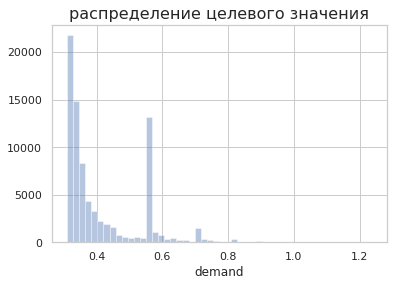

In [77]:
sns.distplot(np.log1p(np.log1p(df['demand'] * std + mean)),kde=False)
plt.title('распределение целевого значения', fontsize=16)
plt.show()

In [59]:
df = df[df['month'] > 3]

In [78]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

categorical = list(set(df_test.columns).difference(['day', 'dayofyear'])) 

numeric_features = ['day', 'dayofyear']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)])


pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', CatBoostRegressor(iterations=1000, silent=True, random_seed=0))])

X_train, y_train = df.drop(columns='demand'), df['demand']

model = pipeline.fit(X_train, y_train)

demand = model.predict(X_train)
print((np.array(df['demand'] - demand) ** 2).mean())

0.21413120652989437


In [56]:
test = pd.read_csv('hse-dab-lt-naf-22/lt_test.csv')
df_test['id'] = test['id']

In [57]:
submission = df_test[['id', 'product_id']]
submission['demand'] = model.predict(df_test)
submission.drop(columns=['product_id'], inplace=True)

clear_output()

In [58]:
submission

,id,demand
0,601,0.138648
1,697,0.142310
2,831,0.146812
3,875,1.181677
4,975,0.142310
...,...,...
10164,408050,0.830359
10165,408051,0.830359
10166,408052,0.830359
10167,408053,0.760124


In [66]:
submission.to_csv('res.csv', index=None)